In [ ]:
!pip install mediapipe opencv-python-headless
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving IMG_5856.MOV to IMG_5856.MOV


In [ ]:
!ffmpeg -i IMG_5856.MOV -vcodec libx264 output.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
import os
print("Files in current directory:", os.listdir())

Files in current directory: ['.config', 'IMG_5855.MOV', 'IMG_5856.MOV', 'output.mp4', 'sample_data']


✅ Video file opened successfully.
First frame read: True


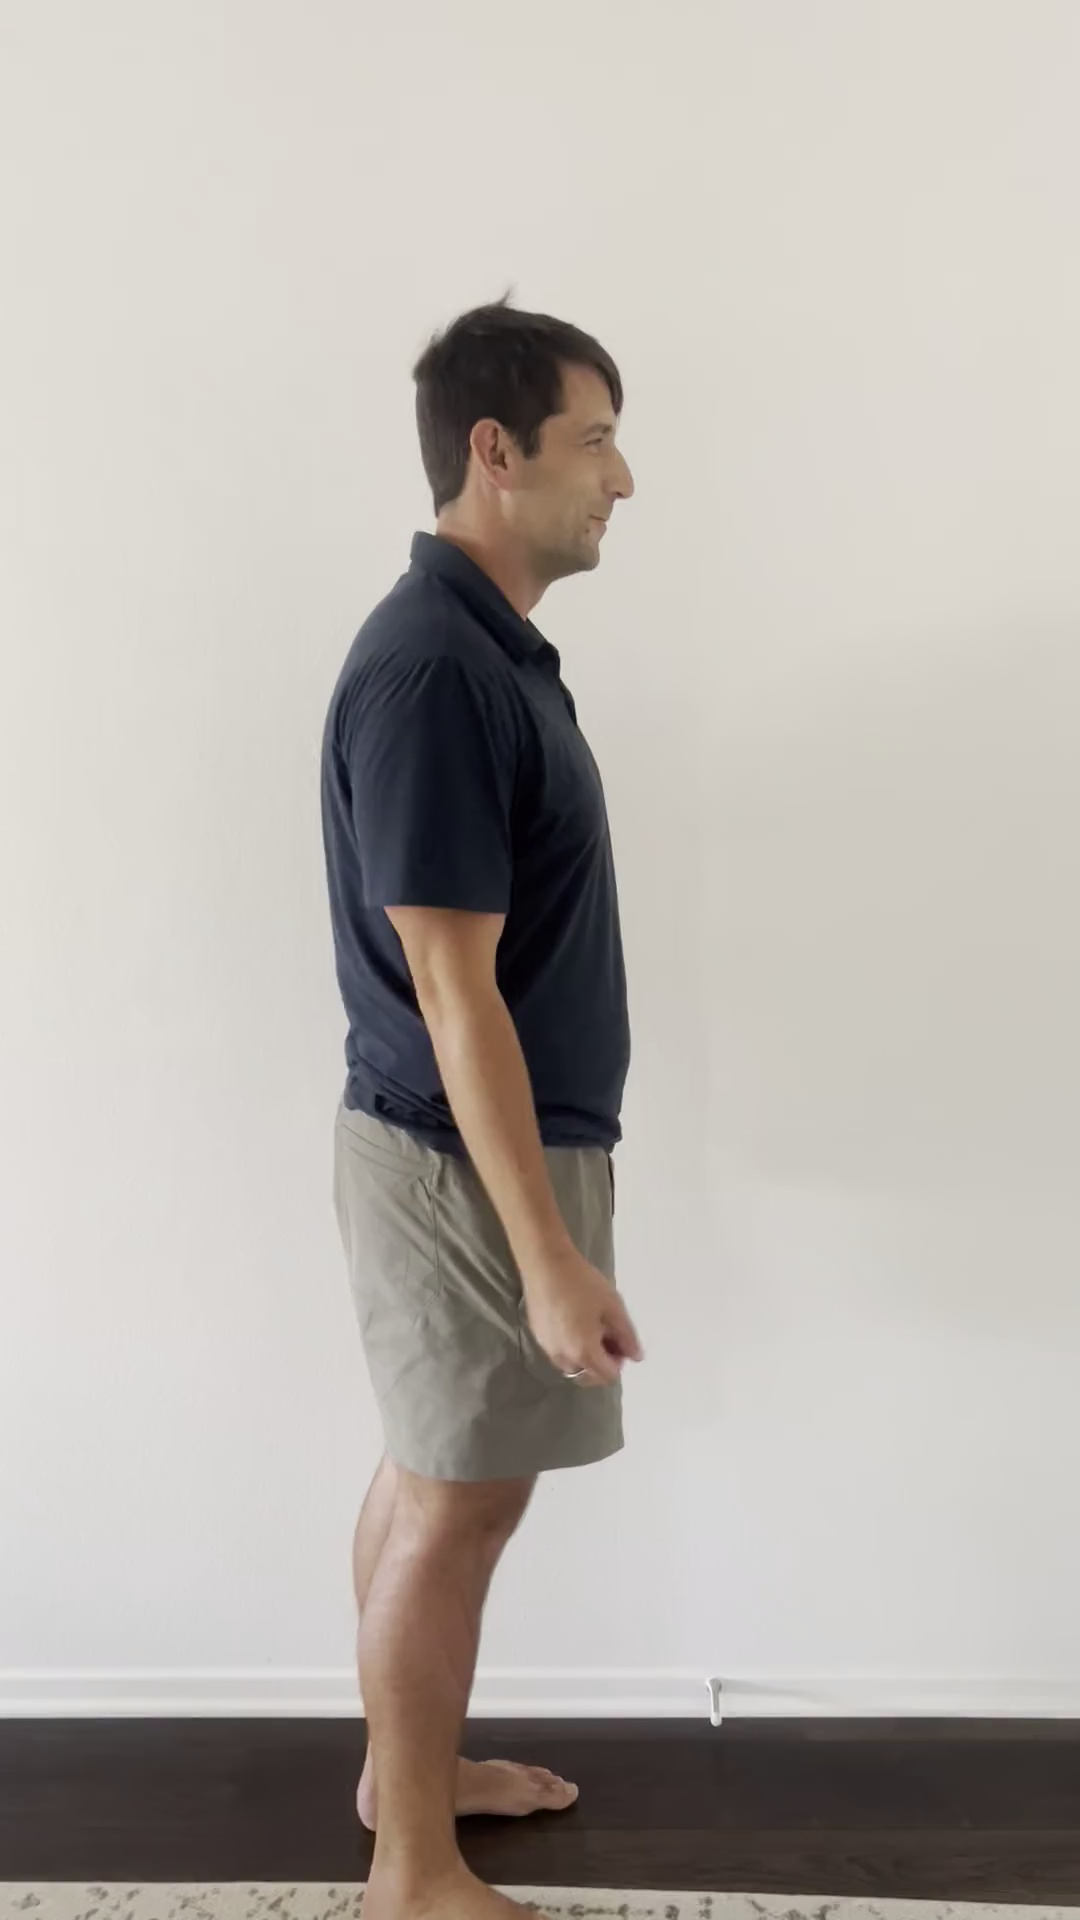

In [ ]:
cap = cv2.VideoCapture("output.mp4")

if not cap.isOpened():
    print("❌ Error: Video file could not be opened.")
else:
    print("✅ Video file opened successfully.")

# Try to read the first frame
ret, frame = cap.read()
print("First frame read:", ret)

if ret:
    # Save and display the first frame
    cv2.imwrite("first_frame.jpg", frame)
    from PIL import Image
    display(Image.open("first_frame.jpg"))
else:
    print("⚠️ Frame read failed. The video may not be encoded in a format OpenCV can read.")




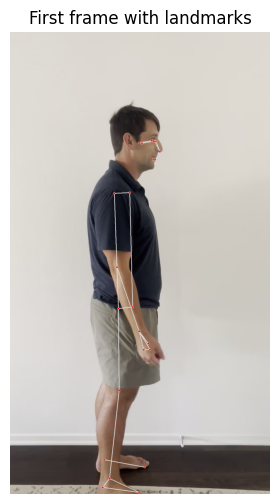

In [ ]:
with mp_pose.Pose(static_image_mode=True) as pose:
    results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("First frame with landmarks")
        plt.show()
    else:
        print("❌ No pose landmarks detected in first frame.")

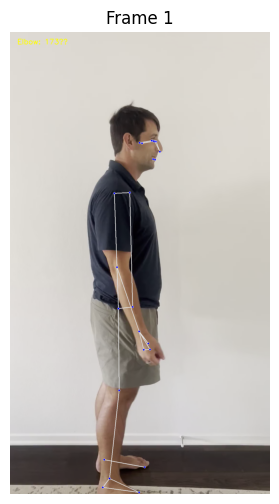

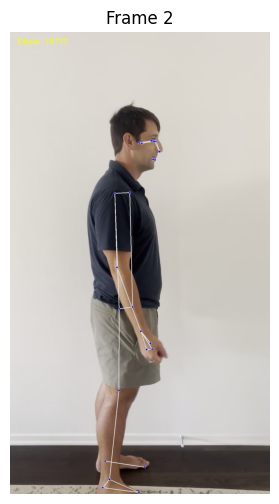

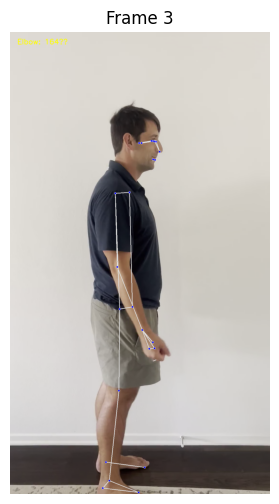

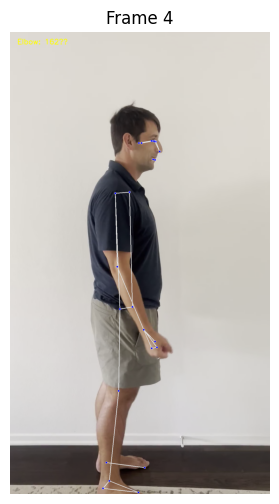

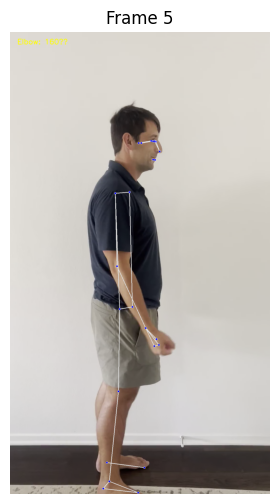

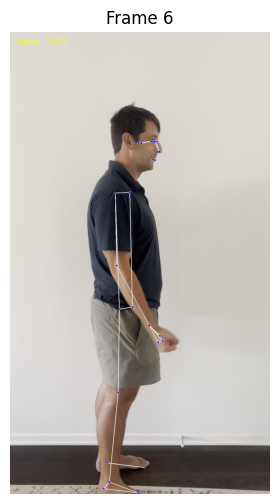

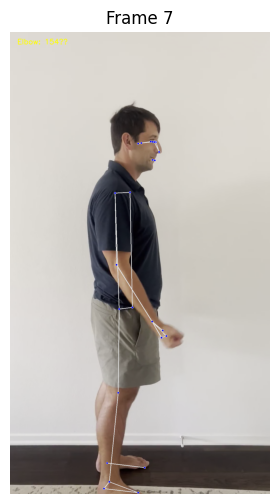

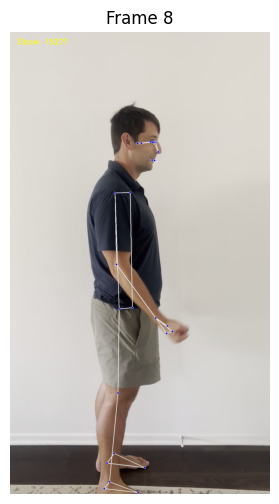

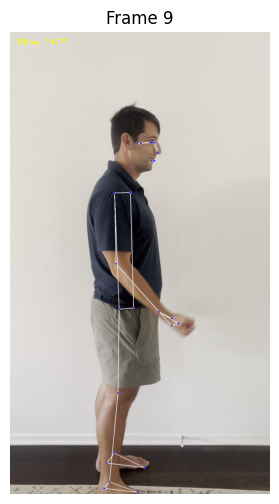

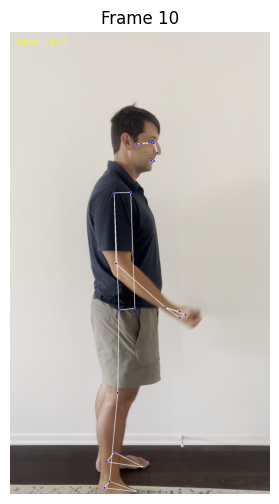

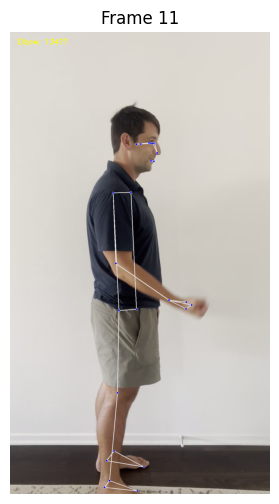

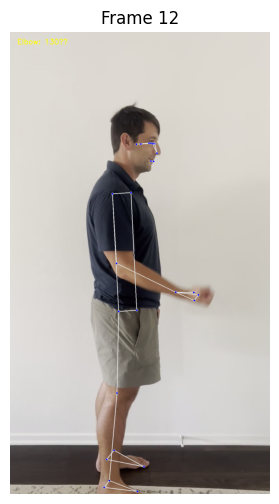

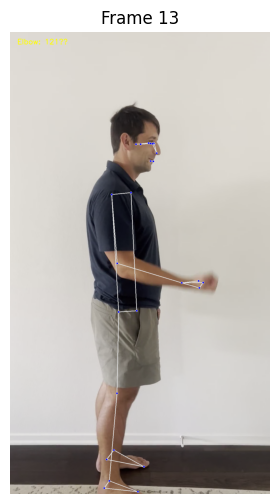

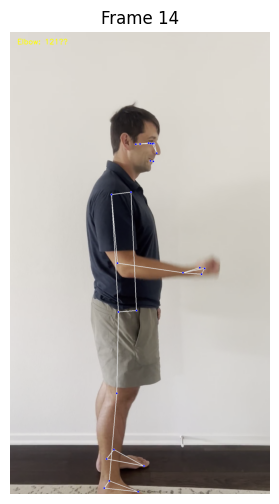

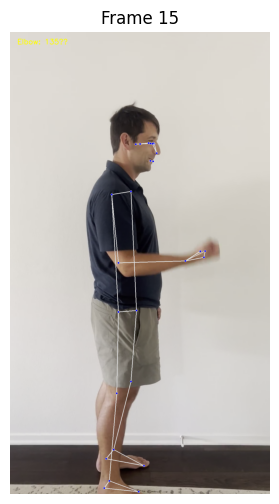

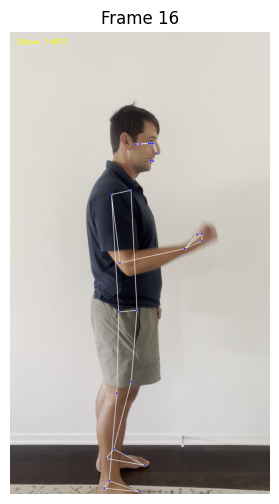

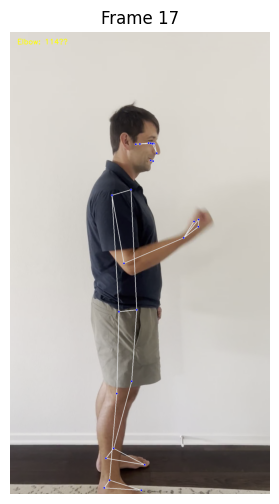

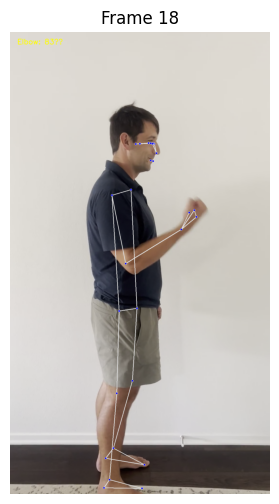

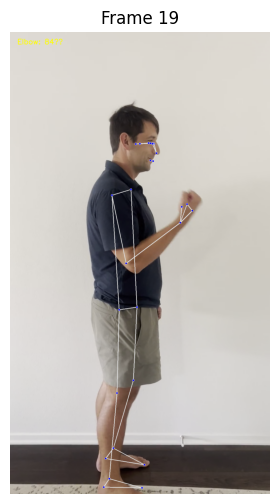

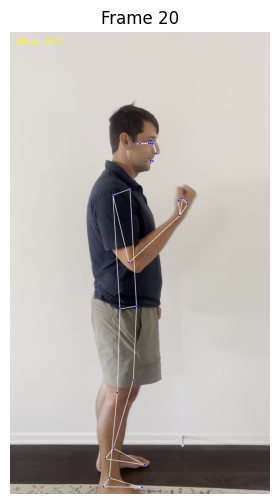

✅ Frames processed: 142
✅ Pose frames detected: 142


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# Use MediaPipe Holistic
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

# Angle calculation helper
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    radians = np.arccos(np.clip(np.dot(a - b, c - b) /
                                (np.linalg.norm(a - b) * np.linalg.norm(c - b)), -1.0, 1.0))
    return np.degrees(radians)

# Open video
cap = cv2.VideoCapture("output.mp4")
elbow_angles = []
frame_numbers = []
pose_detected = 0
max_frames_to_show = 20

with mp_holistic.Holistic(static_image_mode=False,
                          model_complexity=1,
                          min_detection_confidence=0.5,
                          min_tracking_confidence=0.5) as holistic:

    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_idx += 1

        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(image_rgb)

        # Use pose landmarks from holistic
        if results.pose_landmarks:
            pose_detected += 1
            landmarks = results.pose_landmarks.landmark

            try:
                # Extract shoulder, elbow, wrist (LEFT side)
                shoulder = [landmarks[mp_holistic.PoseLandmark.LEFT_SHOULDER.value].x,
                            landmarks[mp_holistic.PoseLandmark.LEFT_SHOULDER.value].y]
                elbow = [landmarks[mp_holistic.PoseLandmark.LEFT_ELBOW.value].x,
                         landmarks[mp_holistic.PoseLandmark.LEFT_ELBOW.value].y]
                wrist = [landmarks[mp_holistic.PoseLandmark.LEFT_WRIST.value].x,
                         landmarks[mp_holistic.PoseLandmark.LEFT_WRIST.value].y]

                angle = calculate_angle(shoulder, elbow, wrist)
                elbow_angles.append(angle)
                frame_numbers.append(frame_idx)

                # Draw landmarks and show initial frames
                annotated = image_rgb.copy()
                mp_drawing.draw_landmarks(annotated, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)

                # Annotate with elbow angle
                cv2.putText(annotated, f'Elbow Angle in Degrees: {int(angle)}', (30, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 4)

                if len(elbow_angles) <= max_frames_to_show:
                    plt.figure(figsize=(8, 6))
                    plt.imshow(annotated)
                    plt.axis('off')
                    plt.title(f'Frame {frame_idx}')
                    plt.show()

            except Exception as e:
                print("Landmark error:", e)
                continue

cap.release()
print(f"✅ Frames processed: {frame_idx}")
print(f"✅ Pose frames detected: {pose_detected}")


In [ ]:
# Thresholds for rep detection
min_flexed_threshold = 80     # Fully flexed
max_extended_threshold = 150  # Fully extended

reps = []
in_rep = False

for i in range(1, len(elbow_angles)):
    angle = elbow_angles[i]

    if not in_rep and angle < min_flexed_threshold:
        in_rep = True

    elif in_rep and angle > max_extended_threshold:
        reps.append(frame_numbers[i])
        in_rep = False

print(f"✅ Total curl reps detected: {len(reps)}")
print(f"📍 Rep completion frames: {reps}")


✅ Total curl reps detected: 2
📍 Rep completion frames: [36, 87]


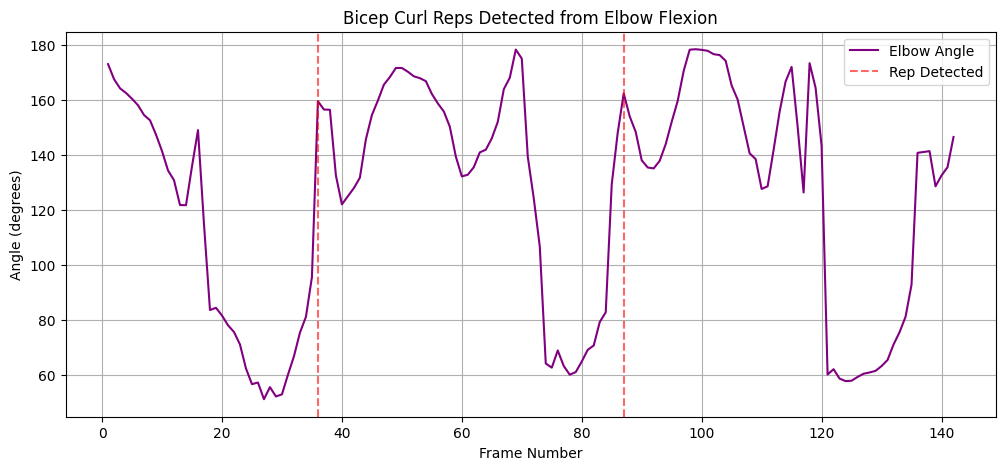

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(frame_numbers, elbow_angles, label="Elbow Angle", color='purple')

# Mark detected reps with vertical lines
for rep_frame in reps:
    plt.axvline(x=rep_frame, color='red', linestyle='--', alpha=0.6,
                label='Rep Detected' if rep_frame == reps[0] else "")

plt.xlabel("Frame Number")
plt.ylabel("Angle (degrees)")
plt.title("Bicep Curl Reps Detected from Elbow Flexion")
plt.legend()
plt.grid(True)
plt.show()
